In [2]:
import pandas as pd
import os
import seaborn as sns
import scipy.stats as sps
from IPython.core.display import display, HTML
import swifter
import multiprocessing as mp
import numpy as np
pd.set_option('precision', 2)

In [ ]:
wilcoxgreater = lambda data: sps.wilcoxon(data, alternative='greater').pvalue

In [4]:
def readcsv(loc):
    return pd.read_csv("{0}/{1}".format(loc[0], loc[1]))

def readScatteredResults(dset, dire="bayesian_results"):
    n = 8
    pool = mp.Pool(n)
    files = os.listdir(dire)
    files = list(filter(lambda name: ".csv" in name and dset in name, files))
    args = list(zip([dire for i in range(len(files))], files))
    cs = max(int(np.ceil(len(files)/(4*n))),1)
    reading = pool.map(readcsv, args, chunksize=cs)
    pool.close()
    pool.join()
    return pd.concat(reading)

def readSyntheticNoisy(dire):
    files = os.listdir(dire)
    files = list(filter(lambda name: ".csv" in name and "largeSyntheticNoisy" in name, files))
    frames = []
    for file in files:
        h, dset, size, seed, method, rest = file.split("_")
        dset = "_".join([dset, size])
        data = pd.read_csv("{0}/{1}".format(dire, file))
        data['dset'] = dset
        data['seed'] = seed
        frames.append(data)
    return pd.concat(frames)

def removeSuffix(keywords, columns):
    return ["_".join(col.split("_")[:2]) if all([key in col for key in keywords]) else col for col in columns]

def renameColumns(dset, renames):
    columns = dset.columns
    renamed = []
    for col in columns:
        for key in renames.keys():
            if key in col:
                col = renames[key]
        renamed.append(col)
    dset.columns = renamed
    return dset

def replaceInColName(dset, substring, replacement):
    columns = dset.columns
    dset.columns = [col.replace(substring, replacement) for col in columns]
    return dset

In [5]:
locations = ["new run/kh=h", "new run/kh=1"] # folder containing .csv files
dsets = ["tourism", "infantgts"] # Dset name on .csv file name to look for

In [6]:
total = pd.DataFrame()
for location in locations:
    for key in dsets:
        
        print(key)
        results = readScatteredResults(key, dire=location).sort_values(['h', 'iTest', 'fmethod'])    
        results = results.loc[:, ~results.columns.duplicated()]
        
        # Getting rid of seed
        if key in ('largeSynthetic', 'syntheticLarge'):
            results['dset'] = results['dset'].swifter.apply(lambda name: name.replace("largeSynthetic", "syntheticLarge"))
            splits = results['dset'].str.split("_")
            name = splits.apply(lambda sp: "_".join(sp[:-1]))
            seed = splits.apply(lambda sp: sp[-1])
            results['dset'] = name
            results['seed'] = seed
        else:
            results['seed'] = "seed0"

        if "kh=h" in location:
            results['kh'] = results['h'].copy()
            results['run'] = "kh=h"
        elif "kh=1" in location:
            results['kh'] = 1
            results['run'] = "kh=1"
        else:
            print("something went wrong")

        total = total.append(results)
    
total = total.set_index(['dset', 'h', 'fmethod', 'iTest', "kh", "run"])
print(len(total))

tourism
infantgts
largeSynthetic


/Users/joaopedroaugusto/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



syntheticLarge
tourism
infantgts
largeSynthetic



syntheticLarge
291650


In [7]:
grouper_kh = 'run' #kh
total = total.groupby([grouper_kh, 'dset', 'h', 'fmethod', 'iTest', "seed"]).agg('mean').reset_index()
total = total.set_index([grouper_kh, 'dset', 'h', 'fmethod'])
print(len(total))

291648


In [8]:
counter = total.groupby(['dset',grouper_kh, 'h', 'fmethod']).agg({'rmseMeanAll_Base':'count', 'seed': 'nunique'})
counter.filter(regex='syntheticLargeVeryNoisy_n50',axis=0)

rmseMeanAll_Base  seed
dset                        run  h fmethod                        
syntheticLargeVeryNoisy_n50 kh=1 1 arima                1008    42
                                   ets                  1008    42
                                 2 arima                1012    44
                                   ets                  1012    44
                                 3 arima                1012    46
                                   ets                  1012    46
                                 4 arima                1008    48
                                   ets                  1008    48
                            kh=h 1 arima                1008    42
                                   ets                  1008    42
                                 2 arima                1012    44
                                   ets                  1012    44
                                 3 arima                1012    46
                                   ets                  1012    46
                                 4 arima                1008    48
                                   ets                  1008    48

In [9]:
variable='esAll'
filtered = total.filter(regex=variable)
all_ = filtered
map_ = {"{0}_Base".format(variable): "Base",
        "{0}_BottomUp".format(variable): "BU",
       "{0}_Corr".format(variable): "pMinT",
       "{0}_Indep".format(variable): "LG"}

## Energy Score Ratio between kh=h/kh=1 for infantgts and tourism

In [10]:
# Ratio between kh=1 and kh=h
cols = ['dset', 'fmethod', 'h', 'run', 'iTest'] + list(all_.columns)
study = total.reset_index()[cols].set_index(['dset', 'iTest', 'h', 'fmethod'])
study = study.filter(regex="infantgts|tourism",axis=0)#.drop(columns=['{0}_Base'.format(variable)])
kh1 = study[study['run'] == 'kh=1'].copy().drop(columns='run')
khh = study[study['run'] == 'kh=h'].copy().drop(columns='run')

In [11]:
es_ratios = (khh/kh1)
es_ratios.columns = [map_[col] for col in es_ratios.columns]
print(es_ratios.isna().sum())
h_agg = es_ratios.groupby(['dset', 'h', 'fmethod']).agg(['median'])

print(h_agg.sort_values(['dset', 'fmethod', 'h']).to_latex(caption="Ratios kh=h/kh=1"))
h_agg.sort_values(['dset', 'fmethod', 'h'])

Base     0
BU       0
pMinT    0
LG       0
dtype: int64
\begin{table}
\centering
\caption{Ratios kh=h/kh=1}
\begin{tabular}{lllrrrr}
\toprule
        &   &     &   Base &     BU &  pMinT &     LG \\
        &   &     & median & median & median & median \\
dset & h & fmethod &        &        &        &        \\
\midrule
infantgts & 1 & arima &   1.00 &   1.00 &   1.00 &   1.00 \\
        & 2 & arima &   1.10 &   1.06 &   1.07 &   0.99 \\
        & 3 & arima &   1.13 &   1.06 &   1.01 &   0.95 \\
        & 4 & arima &   1.06 &   0.99 &   0.95 &   0.92 \\
        & 1 & ets &   1.00 &   1.00 &   1.00 &   1.00 \\
        & 2 & ets &   1.11 &   1.06 &   1.06 &   1.00 \\
        & 3 & ets &   1.14 &   1.11 &   1.13 &   0.98 \\
        & 4 & ets &   1.09 &   1.03 &   1.04 &   0.92 \\
tourism & 1 & arima &   1.00 &   1.00 &   1.00 &   1.00 \\
        & 2 & arima &   1.05 &   0.99 &   0.97 &   0.95 \\
        & 3 & arima &   1.11 &   1.02 &   0.99 &   0.93 \\
        & 4 & arima &   1.19 &   

Base     BU  pMinT     LG
                    median median median median
dset      h fmethod                            
infantgts 1 arima     1.00   1.00   1.00   1.00
          2 arima     1.10   1.06   1.07   0.99
          3 arima     1.13   1.06   1.01   0.95
          4 arima     1.06   0.99   0.95   0.92
          1 ets       1.00   1.00   1.00   1.00
          2 ets       1.11   1.06   1.06   1.00
          3 ets       1.14   1.11   1.13   0.98
          4 ets       1.09   1.03   1.04   0.92
tourism   1 arima     1.00   1.00   1.00   1.00
          2 arima     1.05   0.99   0.97   0.95
          3 arima     1.11   1.02   0.99   0.93
          4 arima     1.19   1.05   1.01   0.94
          1 ets       1.00   1.00   1.00   1.00
          2 ets       1.04   1.00   0.97   0.95
          3 ets       1.10   1.03   0.97   0.93
          4 ets       1.16   1.09   0.98   0.93

In [12]:
agg = h_agg.groupby(['dset', 'fmethod']).agg(['mean'])
agg = agg.drop(columns=('Base','median','mean'))
print(agg.to_latex(caption="Ratios kh=h/kh=1"))
agg

\begin{table}
\centering
\caption{Ratios kh=h/kh=1}
\begin{tabular}{llrrr}
\toprule
        &     &     BU &  pMinT &     LG \\
        &     & median & median & median \\
        &     &   mean &   mean &   mean \\
dset & fmethod &        &        &        \\
\midrule
infantgts & arima &   1.03 &   1.01 &   0.97 \\
        & ets &   1.05 &   1.06 &   0.97 \\
tourism & arima &   1.02 &   0.99 &   0.96 \\
        & ets &   1.03 &   0.98 &   0.95 \\
\bottomrule
\end{tabular}
\end{table}



BU  pMinT     LG
                  median median median
                    mean   mean   mean
dset      fmethod                     
infantgts arima     1.03   1.01   0.97
          ets       1.05   1.06   0.97
tourism   arima     1.02   0.99   0.96
          ets       1.03   0.98   0.95

## Energy Scores

In [13]:
pd.set_option('precision', 2)
dset = 'syntheticLargeVeryNoisy_'
order = ['{0}n10'.format(dset),'{0}n50'.format(dset),'{0}n100'.format(dset),'{0}n1000'.format(dset)]
m = 'arima|ets'
firstAgg = 'mean'
tbl = all_.groupby(['dset', grouper_kh,'h','fmethod']).agg([firstAgg]).sort_values([grouper_kh, 'dset', 'fmethod']).filter(regex=dset,axis=0)
tbl = tbl.filter(regex=m,axis=0)
renamed = [(map_[c[0]],c[1]) for c in tbl.columns]#[map_[c] for c in tbl.columns] # #
tbl.columns = pd.MultiIndex.from_tuples(renamed)
tbl = tbl.drop(columns=("Base", firstAgg))
tbl = tbl.groupby(['dset', 'run', 'fmethod']).agg(['mean'])

if "synthetic" in dset:
    reorder = []
    for index in tbl.index:
        n = int(index[0].split("_")[-1].replace("n",""))
        new = [n, index]
        reorder.append(new)
    reorder = [i[1] for i in sorted(reorder, key=lambda tpls: tpls[0])]
    tbl = tbl.reindex(reorder)

tbl = tbl.reindex(reorder)
print(tbl.to_latex(caption="Mean ES Distribution averaged over H's"))
tbl

\begin{table}
\centering
\caption{Mean ES Distribution averaged over H's}
\begin{tabular}{lllrrr}
\toprule
                              &      &     &     BU &  pMinT &     LG \\
                              &      &     &   mean &   mean &   mean \\
                              &      &     &   mean &   mean &   mean \\
dset & run & fmethod &        &        &        \\
\midrule
syntheticLargeVeryNoisy\_n10 & kh=1 & arima &  11.60 &  11.59 &  11.71 \\
                              &      & ets &  13.51 &  13.62 &  13.70 \\
                              & kh=h & arima &  11.43 &  11.06 &  11.10 \\
                              &      & ets &  12.95 &  12.84 &  12.86 \\
syntheticLargeVeryNoisy\_n50 & kh=1 & arima &   9.66 &   9.66 &   9.81 \\
                              &      & ets &   9.90 &   9.92 &  10.10 \\
                              & kh=h & arima &   9.69 &   9.55 &   9.47 \\
                              &      & ets &   9.93 &   9.80 &   9.75 \\
syntheticLargeVeryNoisy\

BU  pMinT     LG
                                             mean   mean   mean
                                             mean   mean   mean
dset                          run  fmethod                     
syntheticLargeVeryNoisy_n10   kh=1 arima    11.60  11.59  11.71
                                   ets      13.51  13.62  13.70
                              kh=h arima    11.43  11.06  11.10
                                   ets      12.95  12.84  12.86
syntheticLargeVeryNoisy_n50   kh=1 arima     9.66   9.66   9.81
                                   ets       9.90   9.92  10.10
                              kh=h arima     9.69   9.55   9.47
                                   ets       9.93   9.80   9.75
syntheticLargeVeryNoisy_n100  kh=1 arima     9.13   9.01   9.20
                                   ets       9.48   9.42   9.60
                              kh=h arima     9.23   9.05   8.97
                                   ets       9.56   9.41   9.33
syntheticLargeVeryNoisy_n1000 kh=1 arima     8.83   8.74   8.98
                                   ets       9.55   9.31   9.61
                              kh=h arima     8.98   8.90   8.81
                                   ets       9.65   9.40   9.37

# Improvements

In [14]:
ratios = all_.copy().filter(regex='{0}'.format(variable))
ratiosOverLG = all_.copy().filter(regex='{0}'.format(variable))
baseline = ratios["{0}_BottomUp".format(variable)].copy() # BottomUp as baseline
baselineLG = ratios["{0}_Indep".format(variable)].copy() # LG as baseline
for col in ratios.columns:
    ratios[col] = ratios[col]/baseline
    ratiosOverLG[col] = ratiosOverLG[col]/baselineLG

In [15]:
improvement = (ratios-1)*100
improvementOverLG = (ratiosOverLG-1)*100
cols = ['{0}_Base', '{0}_BottomUp', '{0}_Corr', '{0}_Indep']
cols = [c.format(variable) for c in cols]

In [16]:
#improvement.groupby(['dset', 'run', 'fmethod', 'h']).count().loc['largeSynthetic_n10'].loc['kh=1']

In [17]:
# summ = improvement.groupby(['dset', 'h', grouper_kh, 'fmethod']).agg(['mean']).filter(regex='infantgts|tourism',axis=0).groupby(['dset', grouper_kh, 'fmethod']).agg(['mean'])
# summ.columns = pd.MultiIndex.from_tuples([(map_[c[0]],c[1], c[2]) for c in summ.columns])
# summ.sort_values(['dset', 'fmethod'])

In [18]:
# summ = all_.groupby(['dset', 'h', grouper_kh, 'fmethod']).agg(['mean']).filter(regex='infantgts|tourism',axis=0).groupby(['dset', grouper_kh, 'fmethod']).agg(['mean'])
# summ.columns = pd.MultiIndex.from_tuples([(map_[c[0]],c[1], c[2]) for c in summ.columns])
# summ.sort_values(['dset', 'fmethod'])

In [19]:
pd.options.display.float_format = '{:,.2f}'.format
dset = 'syntheticLargeVeryNoisy'
m = 'ets|arima'

firstAgg = 'median'
tbl = improvement.copy()
tbl = tbl.drop('{0}_Base'.format(variable),axis=1)
tbl = tbl.drop('{0}_BottomUp'.format(variable),axis=1)

tbl = tbl.groupby(['dset', grouper_kh,'h', 'fmethod']).agg([firstAgg]).sort_values([grouper_kh, 'dset','h', 'fmethod']).filter(regex=dset,axis=0)
tbl = tbl.filter(regex=m,axis=0)
agg = tbl.groupby(['dset', grouper_kh, 'fmethod']).agg(['mean']).sort_values(['dset', 'fmethod', 'run'])
renamed = [(map_[c[0]],c[1], c[2]) for c in agg.columns]#[map_[c] for c in tbl.columns] # #
agg.columns = pd.MultiIndex.from_tuples(renamed)
agg = agg.sort_values(['dset', 'run', 'fmethod'])

if "synthetic" in dset:
    reorder = []
    for index in agg.index:
        n = int(index[0].split("_")[-1].replace("n",""))
        new = [n, index]
        reorder.append(new)
    reorder = [i[1] for i in sorted(reorder, key=lambda tpls: tpls[0])]
    agg = agg.reindex(reorder)
    
print(agg.to_latex(caption='Improvements over BU'))
agg




#tbl1 = tbl.filter(regex="kh=1",axis=0).copy()
#tbl1.loc[(dset, "avg mean improv. h = 1 to 4", "kh=1")] = tbl1.mean()
#tbl2 = tbl.filter(regex="kh=h",axis=0).copy()
#tbl2.loc[(dset, "avg mean improv. h = 1 to 4", "kh=h")] = tbl2.mean()
#tbl.loc[(dset, "avg", "", "")] = tbl.mean()
#tbl = tbl.reset_index(level=0, drop=True)
#print(tbl.to_latex(float_format="{:0.1f}%".format, caption="{0} - {1}".format(dset, variable)))
#tbl = tbl1.append(tbl2)
#styled = tbl.style.apply(lambda s: ['background-color: grey' if (i == (dset, "avg mean improv. h = 1 to 4", "kh=1")) or (i == (dset, "avg mean improv. h = 1 to 4", "kh=h")) else '' for i in s.index])
#styled.set_properties(**{'text-aligxn': 'center','border-color':'grey','border-width':'thin','border-style':'solid'})

\begin{table}
\centering
\caption{Improvements over BU}
\begin{tabular}{lllrr}
\toprule
                              &      &     &  pMinT &     LG \\
                              &      &     & median & median \\
                              &      &     &   mean &   mean \\
dset & run & fmethod &        &        \\
\midrule
syntheticLargeVeryNoisy\_n10 & kh=1 & arima &  -0.28 &   0.59 \\
                              &      & ets &   1.16 &   1.88 \\
                              & kh=h & arima &  -4.42 &  -4.86 \\
                              &      & ets &  -2.30 &  -2.34 \\
syntheticLargeVeryNoisy\_n50 & kh=1 & arima &  -0.26 &   0.40 \\
                              &      & ets &  -0.29 &   0.90 \\
                              & kh=h & arima &  -2.02 &  -4.39 \\
                              &      & ets &  -1.81 &  -3.67 \\
syntheticLargeVeryNoisy\_n100 & kh=1 & arima &  -0.91 &  -0.27 \\
                              &      & ets &  -1.01 &  -0.43 \\
                     

pMinT     LG
                                           median median
                                             mean   mean
dset                          run  fmethod              
syntheticLargeVeryNoisy_n10   kh=1 arima    -0.28   0.59
                                   ets       1.16   1.88
                              kh=h arima    -4.42  -4.86
                                   ets      -2.30  -2.34
syntheticLargeVeryNoisy_n50   kh=1 arima    -0.26   0.40
                                   ets      -0.29   0.90
                              kh=h arima    -2.02  -4.39
                                   ets      -1.81  -3.67
syntheticLargeVeryNoisy_n100  kh=1 arima    -0.91  -0.27
                                   ets      -1.01  -0.43
                              kh=h arima    -1.73  -4.64
                                   ets      -1.96  -4.45
syntheticLargeVeryNoisy_n1000 kh=1 arima    -0.05   0.66
                                   ets      -1.33  -0.71
                              kh=h arima    -0.10  -3.66
                                   ets      -1.70  -4.87

In [20]:
pd.options.display.float_format = '{:,.2f}'.format
dset = 'largeSyntheticDiagonal'
m = 'ets|arima'

tbl = improvement.copy()
tbl = tbl.drop('{0}_Base'.format(variable),axis=1)
tbl = tbl.drop('{0}_BottomUp'.format(variable),axis=1)

tbl = tbl.groupby(['dset', grouper_kh,'h', 'fmethod']).agg(['median']).sort_values([grouper_kh, 'dset','h', 'fmethod']).filter(regex=dset,axis=0)
tbl = tbl.filter(regex=m,axis=0)
agg = tbl.groupby(['dset', grouper_kh, 'fmethod']).agg(['mean']).sort_values(['dset', 'fmethod', 'run'])
renamed = [(map_[c[0]],c[1], c[2]) for c in agg.columns]#[map_[c] for c in tbl.columns] # #
agg.columns = pd.MultiIndex.from_tuples(renamed)
agg = agg.sort_values(['dset', 'run', 'fmethod'])
print(agg.to_latex(caption='Improvements over BU'))
agg



#tbl1 = tbl.filter(regex="kh=1",axis=0).copy()
#tbl1.loc[(dset, "avg mean improv. h = 1 to 4", "kh=1")] = tbl1.mean()
#tbl2 = tbl.filter(regex="kh=h",axis=0).copy()
#tbl2.loc[(dset, "avg mean improv. h = 1 to 4", "kh=h")] = tbl2.mean()
#tbl.loc[(dset, "avg", "", "")] = tbl.mean()
#tbl = tbl.reset_index(level=0, drop=True)
#print(tbl.to_latex(float_format="{:0.1f}%".format, caption="{0} - {1}".format(dset, variable)))
#tbl = tbl1.append(tbl2)
#styled = tbl.style.apply(lambda s: ['background-color: grey' if (i == (dset, "avg mean improv. h = 1 to 4", "kh=1")) or (i == (dset, "avg mean improv. h = 1 to 4", "kh=h")) else '' for i in s.index])
#styled.set_properties(**{'text-aligxn': 'center','border-color':'grey','border-width':'thin','border-style':'solid'})

\begin{table}
\centering
\caption{Improvements over BU}
\begin{tabular}{lllrr}
\toprule
\bottomrule
\end{tabular}
\end{table}



,,,pMinT,LG
,,,median,median
,,,mean,mean
dset,run,fmethod,,


In [21]:
tbl
tbl.columns = pd.MultiIndex.from_tuples([(map_[col[0]], col[1]) for col in tbl.columns])
print(tbl.to_latex(caption='Improvements over BU'))
tbl

\begin{table}
\centering
\caption{Improvements over BU}
\begin{tabular}{llllrr}
\toprule
\bottomrule
\end{tabular}
\end{table}



,,,,pMinT,LG
,,,,median,median
dset,run,h,fmethod,,


## Wilcox test

In [22]:
wilcoxgreater = lambda data: sps.wilcoxon(data, alternative='greater').pvalue

dset = 'syntheticLarge_'#'infantgts|tourism'#
m = 'ets|arima'
tbl = improvement.copy()
tbl = tbl.drop('{0}_Base'.format(variable),axis=1)
tbl = tbl.drop('{0}_BottomUp'.format(variable),axis=1)
tbl = tbl.filter(regex=dset, axis=0)
tbl = tbl.filter(regex=m, axis=0)
tbl = tbl.groupby(['dset', grouper_kh,'fmethod']).agg(wilcoxgreater).sort_values(['dset','run', 'fmethod'])
tbl.columns = ['pMinT < BU', 'LG < BU']

In [23]:
tbl

pMinT < BU  LG < BU
dset                 run  fmethod                     
syntheticLarge_n10   kh=1 arima          0.65     0.00
                          ets            0.00     0.00
                     kh=h arima          1.00     1.00
                          ets            0.99     0.11
syntheticLarge_n100  kh=1 arima          0.00     0.00
                          ets            0.00     0.00
                     kh=h arima          0.62     1.00
                          ets            1.00     1.00
syntheticLarge_n1000 kh=1 arima          0.00     0.00
                          ets            0.85     0.00
                     kh=h arima          0.00     1.00
                          ets            0.98     1.00
syntheticLarge_n50   kh=1 arima          0.07     0.00
                          ets            0.00     0.00
                     kh=h arima          1.00     1.00
                          ets            0.96     1.00

In [24]:
tblOverLG = improvementOverLG.copy()
tblOverLG = tblOverLG.drop('{0}_Base'.format(variable),axis=1)
tblOverLG = tblOverLG.drop('{0}_BottomUp'.format(variable),axis=1)
tblOverLG = tblOverLG.drop('{0}_Indep'.format(variable),axis=1)
tblOverLG = tblOverLG.filter(regex=dset, axis=0)
tblOverLG = tblOverLG.filter(regex=m, axis=0)
tblOverLG = tblOverLG.groupby(['dset', grouper_kh,'fmethod']).agg(wilcoxgreater).sort_values(['dset','run', 'fmethod'])
tblOverLG.columns = ['pMinT < LG']

In [25]:
#print(tbl.to_latex(caption='p-values'))
tbl

pMinT < BU  LG < BU
dset                 run  fmethod                     
syntheticLarge_n10   kh=1 arima          0.65     0.00
                          ets            0.00     0.00
                     kh=h arima          1.00     1.00
                          ets            0.99     0.11
syntheticLarge_n100  kh=1 arima          0.00     0.00
                          ets            0.00     0.00
                     kh=h arima          0.62     1.00
                          ets            1.00     1.00
syntheticLarge_n1000 kh=1 arima          0.00     0.00
                          ets            0.85     0.00
                     kh=h arima          0.00     1.00
                          ets            0.98     1.00
syntheticLarge_n50   kh=1 arima          0.07     0.00
                          ets            0.00     0.00
                     kh=h arima          1.00     1.00
                          ets            0.96     1.00

In [26]:
new = pd.merge(left=tbl, right=tblOverLG, how='inner', left_index=True, right_index=True)
#new = new.drop(columns='LG < BU',axis=1)
print(new.to_latex(caption='p-values'))

if "synthetic" in dset:
    reorder = []
    for index in new.index:
        n = int(index[0].split("_")[-1].replace("n",""))
        i = [n, index]
        reorder.append(i)
    reorder = [i[1] for i in sorted(reorder, key=lambda tpls: tpls[0])]
    new = new.reindex(reorder)
    
new

\begin{table}
\centering
\caption{p-values}
\begin{tabular}{lllrrr}
\toprule
                   &      &     &  pMinT < BU &  LG < BU &  pMinT < LG \\
dset & run & fmethod &             &          &             \\
\midrule
syntheticLarge\_n10 & kh=1 & arima &        0.65 &     0.00 &        1.00 \\
                   &      & ets &        0.00 &     0.00 &        1.00 \\
                   & kh=h & arima &        1.00 &     1.00 &        1.00 \\
                   &      & ets &        0.99 &     0.11 &        1.00 \\
syntheticLarge\_n100 & kh=1 & arima &        0.00 &     0.00 &        1.00 \\
                   &      & ets &        0.00 &     0.00 &        1.00 \\
                   & kh=h & arima &        0.62 &     1.00 &        0.00 \\
                   &      & ets &        1.00 &     1.00 &        0.00 \\
syntheticLarge\_n1000 & kh=1 & arima &        0.00 &     0.00 &        0.97 \\
                   &      & ets &        0.85 &     0.00 &        1.00 \\
                   & 

pMinT < BU  LG < BU  pMinT < LG
dset                 run  fmethod                                 
syntheticLarge_n10   kh=1 arima          0.65     0.00        1.00
                          ets            0.00     0.00        1.00
                     kh=h arima          1.00     1.00        1.00
                          ets            0.99     0.11        1.00
syntheticLarge_n50   kh=1 arima          0.07     0.00        1.00
                          ets            0.00     0.00        1.00
                     kh=h arima          1.00     1.00        0.00
                          ets            0.96     1.00        0.00
syntheticLarge_n100  kh=1 arima          0.00     0.00        1.00
                          ets            0.00     0.00        1.00
                     kh=h arima          0.62     1.00        0.00
                          ets            1.00     1.00        0.00
syntheticLarge_n1000 kh=1 arima          0.00     0.00        0.97
                          ets            0.85     0.00        1.00
                     kh=h arima          0.00     1.00        0.00
                          ets            0.98     1.00        0.00

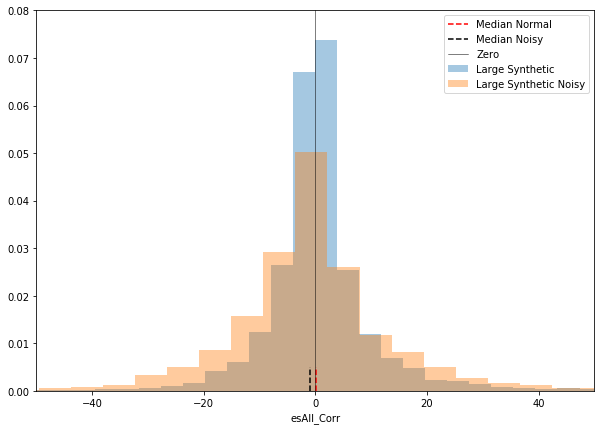

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))

m = 'arima'

sns.distplot(improvement.loc['kh=1'].loc["syntheticLarge_n100"].filter(regex=m,axis=0)['esAll_Corr'], kde=False, ax=ax, norm_hist=True, label='Large Synthetic')
sns.distplot(improvement.loc['kh=1'].loc["syntheticLargeVeryNoisy_n100"].filter(regex=m,axis=0)['esAll_Corr'], kde=False, ax=ax, norm_hist=True, label='Large Synthetic Noisy')

ax.set_xlim([-50, 50])
ax.set_ylim([0, 0.08])

med1 = improvement.loc['kh=1'].loc["syntheticLarge_n100"].filter(regex=m,axis=0)['esAll_Corr'].median()
med2 = improvement.loc['kh=1'].loc["syntheticLargeVeryNoisy_n100"].filter(regex=m,axis=0)['esAll_Corr'].median()

ax.plot([med1, med1], [0.0, 0.005], 'r--', label='Median Normal')
ax.plot([med2, med2], [0.0, 0.005], 'k--', label='Median Noisy')
ax.plot([0, 0], [0.0, 0.08], 'k',lw=0.5, label='Zero')
ax.legend()

In [52]:
med2

-0.9084492013796464

In [ ]:
med2

In [ ]:
improvement.loc['kh=1'].loc["largeSynthetic_n100"].filter(regex='arima',axis=0)['esAll_Corr'].median()

In [ ]:
df1 = pd.DataFrame([1, 1, 1, 1, 1], index=[ 1, 2, 3, 4 ,5 ], columns=['A'])  
df2 = pd.DataFrame([ 1, 1, 1, 1, 1], index=[ 2, 3, 4, 5, 6], columns=['A'])

In [ ]:
df1 + df2